# 训练语言模型

```{note}
就像图像分类一样，语言模型的训练也是类似的，只是模型和数据集不同。<br/>
因此本节我们实现一个训练语言模型的函数，模型和数据集作为其参数。
```

## 预测

In [1]:
import math
import torch
from torch import nn
import d2l


#@save
def predict_language_model(prefix, num_preds, net, vocab):
    """在`prefix`之后生成新的字符"""
    device = d2l.try_gpu()
    # 初始化state
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    # 获取outputs[-1]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    # 得到有意义的state
    for y in prefix[1:]:
        # batch_size和num_steps均为1
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    # 预测`num_preds`步
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        # 得到概率最大的索引
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    # 索引转换成tokens
    return ''.join([vocab.idx_to_token[i] for i in outputs])

## 训练

In [2]:
#@save
def train_language_model(net, train_iter, vocab, lr, num_epochs):
    """训练语言模型"""
    device = try_gpu()
    net = net.to(device=device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr)
    # 记录误差和，tokens总数
    metric = Accumulator(2)
    # 画困惑度曲线
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        metric.reset()
        state = None
        for X, Y in train_iter:
            if state is None:
                # 初始化state
                state = net.begin_state(batch_size=X.shape[0])
            else:
                # state将不会被自动求导，这里分LSTM和非LSTM两种情况讨论
                if isinstance(state, tuple):
                    for s in state:
                        s.detach_()
                else:
                    state.detach_()
            # 前向传播
            y_hat, state = net(X, state)
            # (`batch_size`, `num_steps`)变为(`num_steps` * `batch_size`,)
            y = Y.T.reshape(-1)
            # 计算损失
            loss = loss_fn(y_hat, y.long()).mean()
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # 记录数据
            metric.add(loss * y.numel(), y.numel())
        # 画困惑度曲线
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, [math.exp(metric[0] / metric[1])])
    # predict
    print(predict_language_model("time traveller", 50, net, vocab))

## 应用

In [3]:
# 获取数据
batch_size, num_steps = 32, 40
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
# 创建普通的RNN模型
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))

time traveller and the same the same the same the same the same 


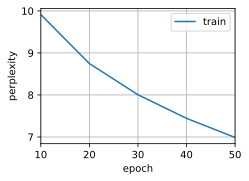

In [5]:
# 训练
num_epochs, lr = 50, 0.1
d2l.train_language_model(net, train_iter, vocab, lr, num_epochs)